**Unsupervised Learning Techniques**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-mlp/blob/main/08_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-mlp/blob/main/08_unsupervised_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Clustering

**Introduction – Classification _vs_ Clustering**

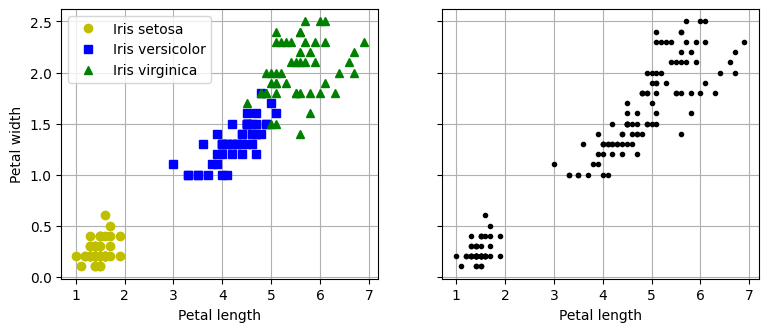

In [1]:
# extra code – this cell generates Figure 8–1

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length")
plt.tick_params(labelleft=False)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

**Observação**: a próxima célula mostra como um modelo de mistura gaussiana (explicado mais adiante neste capítulo) pode separar esses clusters muito bem usando todas as quatro características: comprimento e largura da pétala e comprimento e largura da sépala. Este código mapeia cada cluster para uma classe. Em vez de codificar o mapeamento, o código escolhe a classe mais comum para cada cluster usando a função `scipy.stats.mode()`:

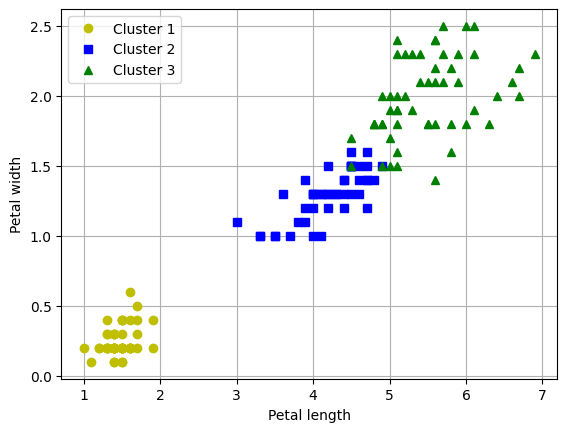

In [2]:
# extra code

import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode] = class_id

y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.grid()
plt.show()

Qual é a proporção de plantas de íris que atribuímos ao grupo certo?

In [3]:
(y_pred==y).sum() / len(y_pred)

np.float64(0.9666666666666667)

## K-Means

**Fit and predict**

Vamos treinar um clusterer K-Means em um conjunto de dados de blobs. Ele tentará encontrar o centro de cada blob e atribuir cada instância ao blob mais próximo:

In [4]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# extra code – the exact arguments of make_blobs() are not important
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, random_state=43)
y_pred = kmeans.fit_predict(X)

Agora vamos plotá-los:

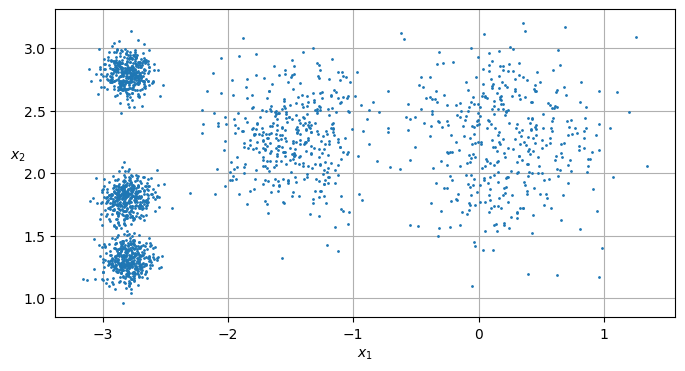

In [5]:
# extra code – this cell generates Figure 8–2

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

Cada instância foi atribuída a um dos 5 clusters:

In [6]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], shape=(2000,), dtype=int32)

In [7]:
y_pred is kmeans.labels_

True

E os seguintes 5 _centróides_ (ou seja, centros de cluster) foram estimados:

In [8]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Observe que a instância `KMeans` preserva os rótulos das instâncias nas quais foi treinada. Um tanto confuso, neste contexto, o _rótulo_ de uma instância é o índice do cluster ao qual a instância é atribuída (eles não são alvos, são previsões):

In [9]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], shape=(2000,), dtype=int32)

Claro, podemos prever os rótulos de novas instâncias:

In [10]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

**Decision Boundaries**

Vamos plotar os limites de decisão do modelo. Isso nos dá um _diagrama de Voronoi_:

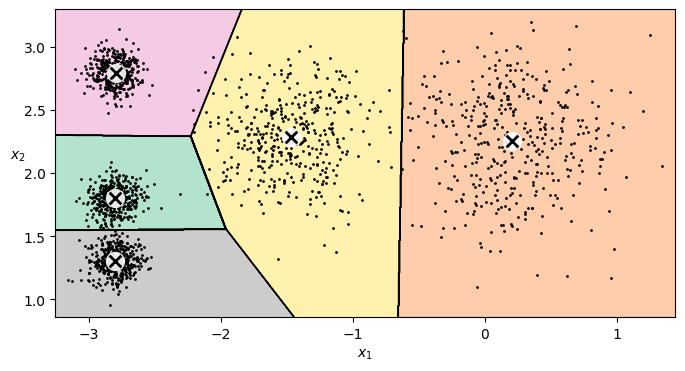

In [11]:
# extra code – this cell generates Figure 8–3

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

plt.show()

Nada mal! Algumas das instâncias próximas às bordas provavelmente foram atribuídas ao cluster errado, mas, no geral, parece muito bom.

**Hard Clustering _vs_ Soft Clustering**

Em vez de escolher arbitrariamente o cluster mais próximo para cada instância, o que é chamado de _agrupamento rígido_, talvez seja melhor medir a distância de cada instância a todos os 5 centroides. Veja o que o método `transform()` faz:

In [12]:
kmeans.transform(X_new).round(2)

array([[2.81, 0.33, 2.9 , 1.49, 2.89],
       [5.81, 2.8 , 5.85, 4.48, 5.84],
       [1.21, 3.29, 0.29, 1.69, 1.71],
       [0.73, 3.22, 0.36, 1.55, 1.22]])

Você pode verificar que esta é de fato a distância euclidiana entre cada instância e cada centróide:

In [13]:
# extra code
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2)
               - kmeans.cluster_centers_, axis=2).round(2)

array([[2.81, 0.33, 2.9 , 1.49, 2.89],
       [5.81, 2.8 , 5.85, 4.48, 5.84],
       [1.21, 3.29, 0.29, 1.69, 1.71],
       [0.73, 3.22, 0.36, 1.55, 1.22]])

### The K-Means Algorithm

O algoritmo K-Means é um dos algoritmos de agrupamento mais rápidos e também um dos mais simples:
* Primeiro, inicialize $k$ centróides aleatoriamente: por exemplo, $k$ instâncias distintas são escolhidas aleatoriamente do conjunto de dados e os centróides são colocados em suas posições.
* Repita até a convergência (ou seja, até que os centróides parem de se mover):
* Atribua cada instância ao centróide mais próximo.
* Atualize os centróides para que sejam a média das instâncias que lhes são atribuídas.

The `KMeans` class uses an optimized initialization technique by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"` and `n_init=1`. More on this later in this chapter.

Vamos executar o algoritmo K-Means para 1, 2 e 3 iterações, para ver como os centróides se movem:

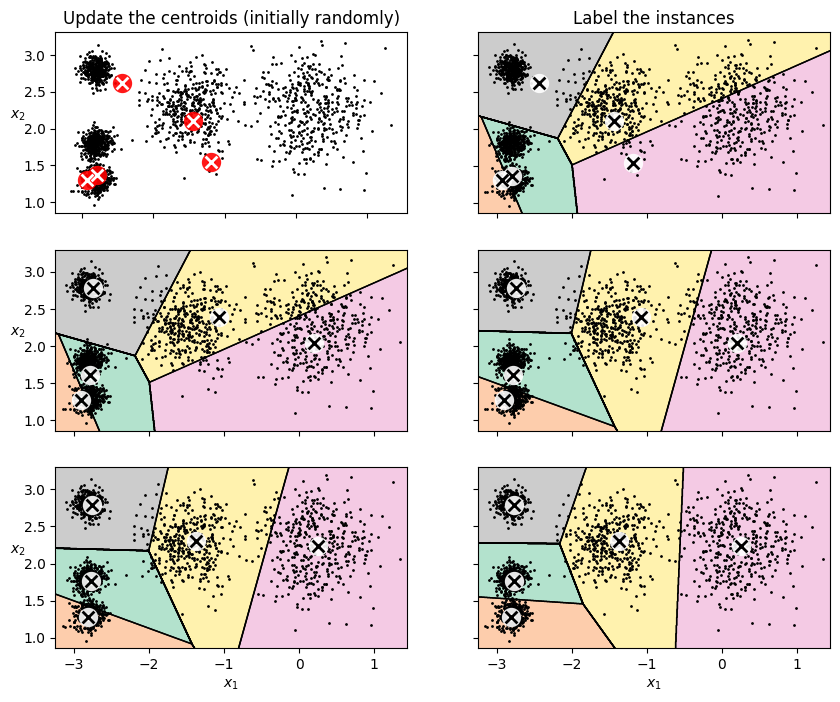

In [14]:
# extra code – this cell generates Figure 8–4

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=18)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=18)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=18)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)


plt.show()

**K-Means Variability**

No algoritmo K-Means original, os centroides são inicializados aleatoriamente, e o algoritmo simplesmente executa uma única iteração para melhorar gradualmente os centroides, como vimos acima.

No entanto, um grande problema com essa abordagem é que, se você executar o K-Means várias vezes (ou com diferentes sementes aleatórias), ele pode convergir para soluções muito diferentes, como você pode ver abaixo:

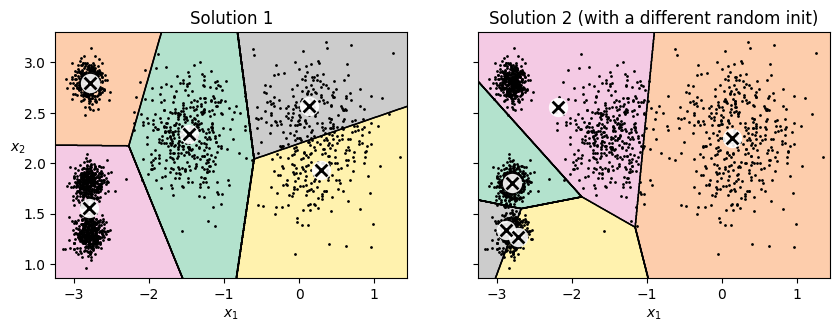

In [15]:
# extra code – this cell generates Figure 8–5

def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=8)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1",
                          "Solution 2 (with a different random init)")


plt.show()

In [16]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, random_state=42)
kmeans.fit(X)

,n_clusters,5
,init,"array([[-3, ... [ 0, 2]])"
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


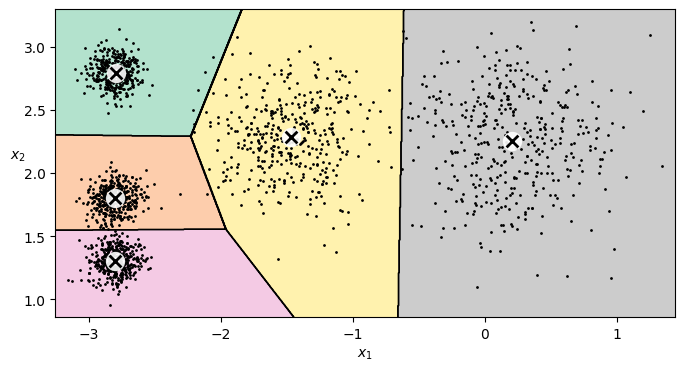

In [17]:
# extra code
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

### Inertia

Para selecionar o melhor modelo, precisaremos de uma maneira de avaliar o desempenho de um modelo K-Mean. Infelizmente, o agrupamento é uma tarefa não supervisionada, então não temos os alvos. Mas pelo menos podemos medir a distância entre cada instância e seu centroide. Esta é a ideia por trás da métrica _inércia_:

In [18]:
kmeans.inertia_

211.59853725816836

In [19]:
kmeans_rnd_init1.inertia_  # extra code

219.5820150360229

In [20]:
kmeans_rnd_init2.inertia_  # extra code

600.3600713094236

Como você pode verificar facilmente, a inércia é a soma das distâncias quadradas entre cada instância de treinamento e seu centróide mais próximo:

In [21]:
# extra code
X_dist = kmeans.transform(X)
(X_dist[np.arange(len(X_dist)), kmeans.labels_] ** 2).sum()

np.float64(211.59853725816805)

O método `score()` retorna a inércia negativa. Por que negativa? Bem, é porque o método `score()` de um preditor deve sempre respeitar a regra "_quanto maior, melhor_".

In [22]:
kmeans.score(X)

-211.59853725816836

### Multiple Initializations

Portanto, uma abordagem para resolver o problema da variabilidade é simplesmente executar o algoritmo K-Means várias vezes com diferentes inicializações aleatórias e selecionar a solução que minimiza a inércia.

O Scikit-Learn executa o algoritmo de inicialização `n_init` vezes e seleciona a solução que minimiza a inércia. Por padrão, o Scikit-Learn define `n_init=1` se `init="k-means++"` (que é o padrão) ou se `init` for um array, ou define `n_init=10` se `init="random"` ou `init` for um chamável.

In [23]:
# extra code
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

,n_clusters,5
,init,'random'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,2
,copy_x,True
,algorithm,'lloyd'


Como você pode ver, terminamos com o modelo inicial, que certamente é a solução K-Means ótima (pelo menos em termos de inércia, e assumindo $k=5$).

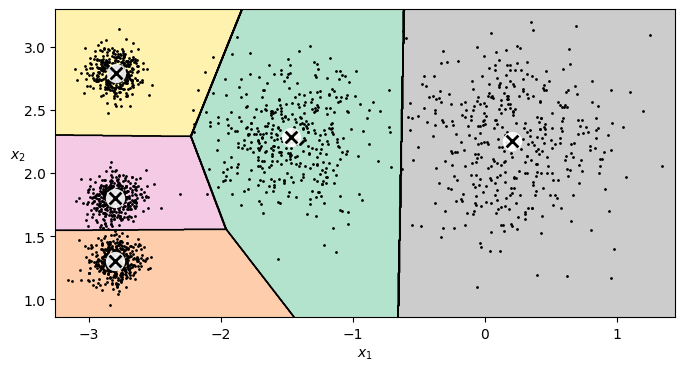

In [24]:
# extra code
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

In [25]:
kmeans_rnd_10_inits.inertia_

211.59853725816836

### Centroid initialization methods

Em vez de inicializar os centroides de forma totalmente aleatória, é preferível inicializá-los usando o seguinte algoritmo, proposto em um artigo de [2006](https://goo.gl/eNUPw6) por David Arthur e Sergei Vassilvitskii:
* Considere um centroide $c_1$, escolhido uniformemente e aleatoriamente no conjunto de dados.
* Considere um novo centro $c_i$, escolhendo uma instância $\mathbf{x}_i$ com probabilidade: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ onde $D(\mathbf{x}_i)$ é a distância entre a instância $\mathbf{x}_i$ e o centroide mais próximo já escolhido. Essa distribuição de probabilidade garante que instâncias mais distantes dos centroides já escolhidos tenham muito mais probabilidade de serem selecionadas como centroides.
* Repita o passo anterior até que todos os $k$ centróides tenham sido escolhidos.

O restante do algoritmo K-Means++ é apenas um K-Means comum. Com essa inicialização, o algoritmo K-Means tem muito menos probabilidade de convergir para uma solução subótima, portanto, é possível reduzir consideravelmente `n_init` (como mencionado anteriormente, `n_init` assume o valor padrão 1 ao usar `init=k-means++`). Na maioria das vezes, o fato de podermos executar muito menos inicializações compensa em grande parte a complexidade adicional do processo de inicialização.

Para definir a inicialização para K-Means++, basta definir `init="k-means++"` (este é, na verdade, o padrão):

### Accelerated K-Means

O algoritmo K-Means pode, às vezes, ser acelerado evitando muitos cálculos de distância desnecessários: isso é obtido explorando a desigualdade triangular (dados três pontos A, B e C, a distância AC é sempre tal que AC ≤ AB + BC) e mantendo o controle dos limites inferior e superior para distâncias entre instâncias e centróides (veja este [artigo de 2003](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) de Charles Elkan para mais detalhes).

Para a variante de Elkan do K-Means, use `algorithm="elkan"`. Para o K-Means regular, use `algorithm="lloyd"` (este é o padrão).

### Mini-Batch K-Means

O Scikit-Learn também implementa uma variante do algoritmo K-Means que suporta minilotes (veja [este artigo](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [26]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

,n_clusters,5
,init,'k-means++'
,max_iter,100
,batch_size,1024
,verbose,0
,compute_labels,True
,random_state,42
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,'auto'


In [27]:
minibatch_kmeans.inertia_

211.6594510571261

**Using `MiniBatchKMeans` along with `memmap`** (not in the book)

Se o conjunto de dados não couber na memória, a opção mais simples é usar a classe `memmap`, assim como fizemos para a ACP incremental no capítulo anterior. Primeiro, vamos carregar o MNIST:

In [28]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

Vamos dividir o conjunto de dados:

In [29]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

Em seguida, vamos escrever o conjunto de treinamento em um `memmap`:

In [30]:
filename = "my_mnist.mmap"
X_memmap = np.memmap(filename, dtype='float32', mode='write',
                     shape=X_train.shape)
X_memmap[:] = X_train
X_memmap.flush()

In [31]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10,
                                   random_state=42)
minibatch_kmeans.fit(X_memmap)

,n_clusters,10
,init,'k-means++'
,max_iter,100
,batch_size,10
,verbose,0
,compute_labels,True
,random_state,42
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,'auto'


### Finding the optimal number of clusters

E se o número de clusters fosse definido como um valor menor ou maior que 5?

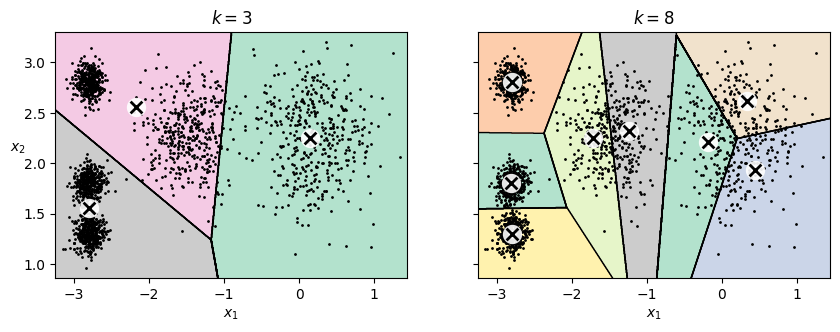

In [32]:
# extra code – this cell generates Figure 8–6

kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")

plt.show()

Nossa, esses dois modelos não parecem nada bons. E quanto às inércias deles?

In [33]:
kmeans_k3.inertia_

653.2167190021554

In [34]:
kmeans_k8.inertia_

127.13141880461836

Não, não podemos simplesmente tomar o valor de $k$ que minimiza a inércia, pois ele diminui à medida que aumentamos $k$. De fato, quanto mais clusters houver, mais próxima cada instância estará do seu centroide mais próximo e, portanto, menor será a inércia. No entanto, podemos plotar a inércia como uma função de $k$ e analisar a curva resultante:

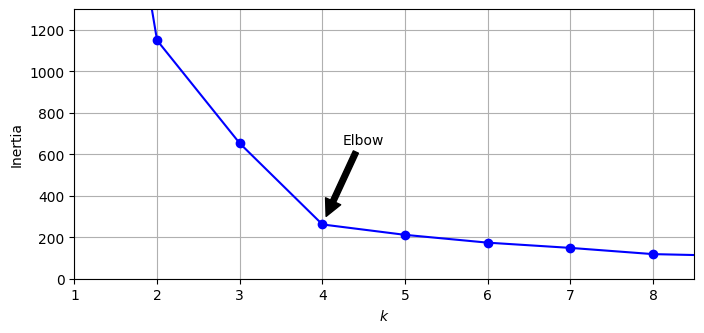

In [35]:
# extra code – this cell generates Figure 8–8

kmeans_per_k = [KMeans(n_clusters=k, random_state=43).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()

plt.show()

Como você pode ver, há um cotovelo em $k=4$, o que significa que menos clusters do que isso seria ruim, e mais clusters não ajudariam muito e poderiam cortá-los pela metade. Portanto, $k=4$ é uma escolha muito boa. É claro que neste exemplo não é perfeito, pois significa que os dois pontos no canto inferior esquerdo serão considerados como um único cluster, mas ainda assim é um cluster muito bom.

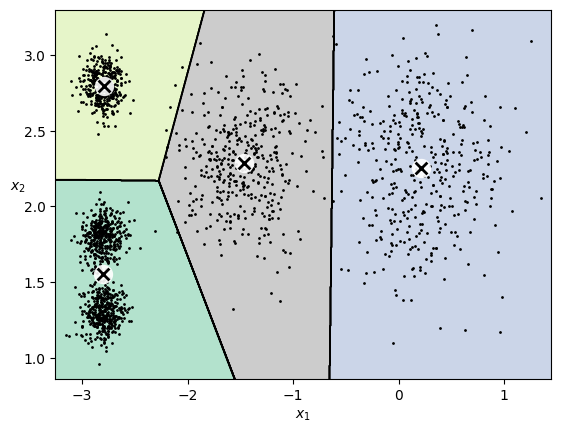

In [36]:
# extra code
plot_decision_boundaries(kmeans_per_k[4 - 1], X)
plt.show()

Outra abordagem é observar a pontuação da silhueta, que é o coeficiente de silhueta médio de todas as instâncias. O coeficiente de silhueta de uma instância é igual a (b - a) / max(a, b), onde a é a distância média até as outras instâncias no mesmo cluster (a distância média intracluster) e b é a distância média até o cluster mais próximo, ou seja, a distância média até as instâncias do cluster mais próximo (definido como aquele que minimiza b, excluindo o próprio cluster da instância). O coeficiente de silhueta pode variar entre -1 e +1: um coeficiente próximo a +1 significa que a instância está bem dentro de seu próprio cluster e longe de outros clusters, enquanto um coeficiente próximo a 0 significa que ela está próxima do limite de um cluster e, finalmente, um coeficiente próximo a -1 significa que a instância pode ter sido atribuída ao cluster errado.

Vamos plotar a pontuação da silhueta como uma função de $k$:

In [37]:
from sklearn.metrics import silhouette_score

In [38]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

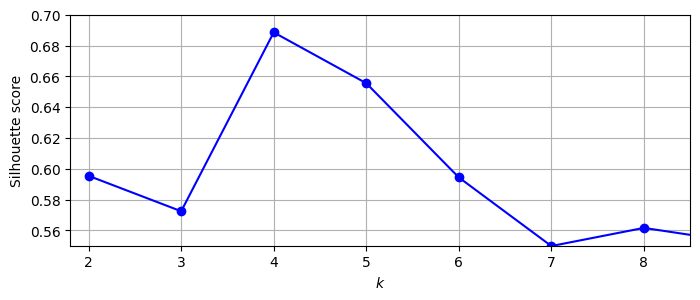

In [39]:
# extra code – this cell generates Figure 8–9

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()

plt.show()

Como você pode ver, esta visualização é muito mais rica que a anterior: em particular, embora confirme que $k=4$ é uma escolha muito boa, também ressalta o fato de que $k=5$ também é muito bom.

Uma visualização ainda mais informativa é obtida quando você plota o coeficiente de silhueta de cada instância, classificado pelo cluster ao qual estão atribuídos e pelo valor do coeficiente. Isso é chamado de _diagrama de silhueta_:

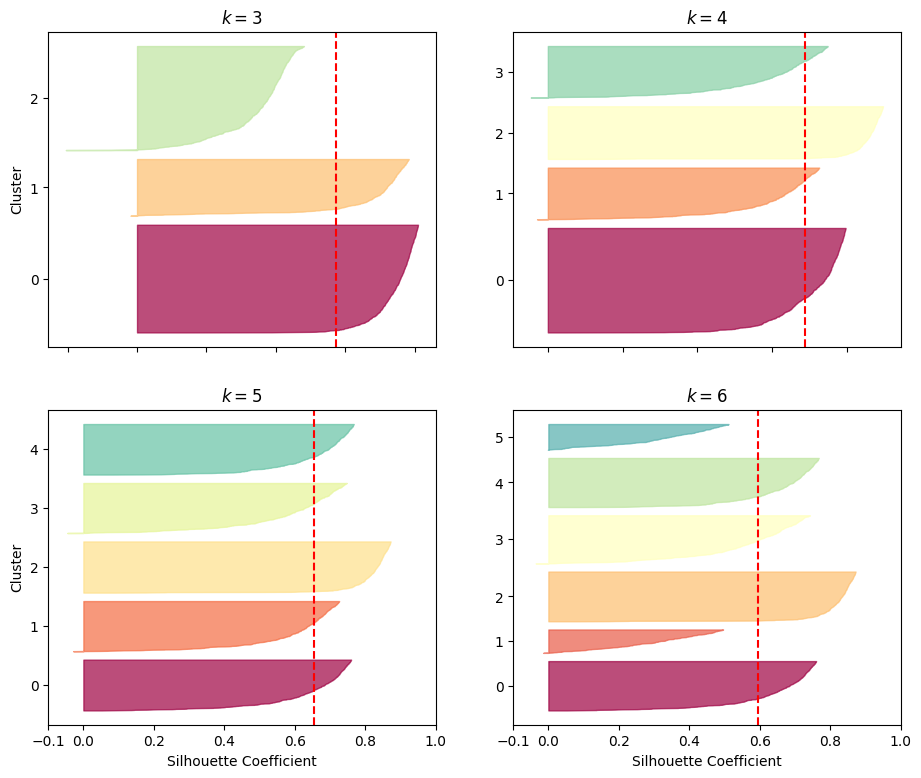

In [40]:
# extra code – this cell generates Figure 8–10

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")


plt.show()

Como você pode ver, $k=5$ parece ser a melhor opção aqui, já que todos os clusters têm aproximadamente o mesmo tamanho e todos cruzam a linha tracejada, que representa a pontuação média da silhueta.

## Limits of K-Means

Vamos gerar um conjunto de dados mais difícil, com bolhas alongadas e densidades variadas, e mostrar que o K-Means tem dificuldade para agrupá-los corretamente:

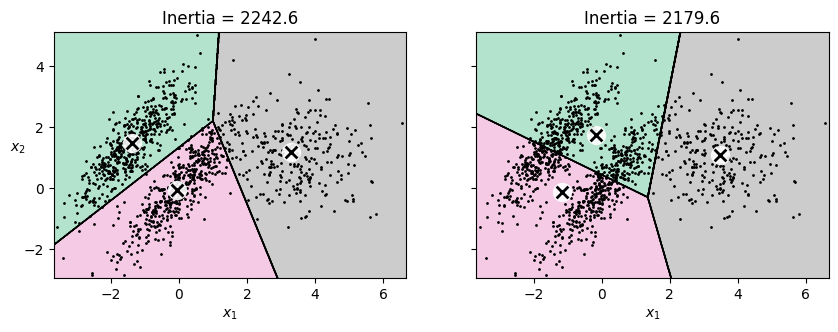

In [41]:
# extra code – this cell generates Figure 8–11

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

kmeans_good = KMeans(n_clusters=3,
                     init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                     random_state=42)
kmeans_bad = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title(f"Inertia = {kmeans_good.inertia_:.1f}")

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title(f"Inertia = {kmeans_bad.inertia_:.1f}")


plt.show()

## Using Clustering for Image Segmentation

Baixe a imagem da joaninha:

In [42]:
# extra code – downloads the ladybug image
from pathlib import Path
import urllib.request

homlp_root = "https://github.com/ageron/handson-mlp/raw/main/"
filename = "ladybug.png"
filepath = Path(f"my_{filename}")
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homlp_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

In [43]:
import PIL

image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

In [44]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

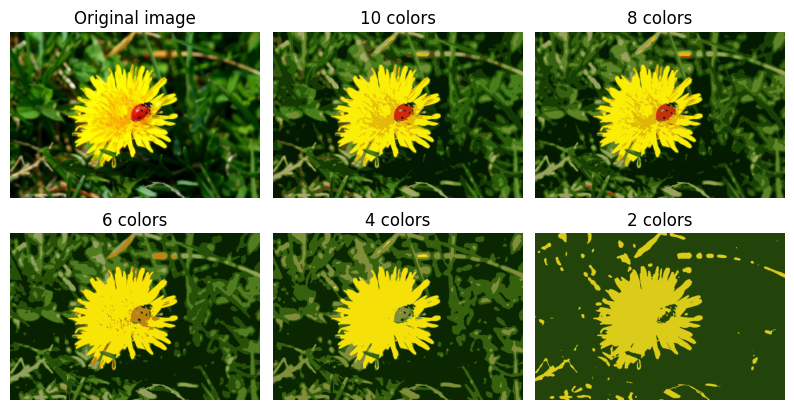

In [45]:
# extra code – this cell generates Figure 8–12

segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis('off')


plt.show()

## Using Clustering for Semi-Supervised Learning

Outro caso de uso para clustering é o aprendizado semissupervisionado, quando temos muitas instâncias não rotuladas e muito poucas instâncias rotuladas.

Vamos abordar o _conjunto de dados de dígitos_, que é um conjunto de dados simples do tipo MNIST contendo 1.797 imagens 8×8 em tons de cinza representando os dígitos de 0 a 9.

In [46]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

Vamos analisar o desempenho de um modelo de regressão logística quando temos apenas 50 instâncias rotuladas:

In [47]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [48]:
log_reg.score(X_test, y_test)

0.7581863979848866

In [49]:
# extra code – measure the accuracy when we use the whole training set
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.9093198992443325

O desempenho é muito inferior ao treinar com apenas 50 imagens aleatórias. Vamos ver como podemos melhorar. Primeiro, vamos agrupar o conjunto de treinamento em 50 grupos e, para cada grupo, encontrar a imagem mais próxima do centroide. Chamaremos essas imagens de imagens representativas:

In [50]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]

Agora vamos plotar essas imagens representativas e rotulá-las manualmente:

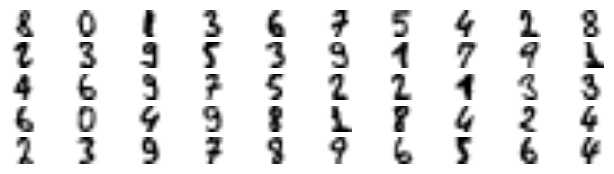

In [51]:
# extra code – this cell generates Figure 8–13

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')


plt.show()

In [52]:
y_representative_digits = np.array([
    8, 0, 1, 3, 6, 7, 5, 4, 2, 8,
    2, 3, 9, 5, 3, 9, 1, 7, 9, 1,
    4, 6, 9, 7, 5, 2, 2, 1, 3, 3,
    6, 0, 4, 9, 8, 1, 8, 4, 2, 4,
    2, 3, 9, 7, 8, 9, 6, 5, 6, 4,
])

Agora temos um conjunto de dados com apenas 50 instâncias rotuladas, mas em vez de serem instâncias completamente aleatórias, cada uma delas é uma imagem representativa do seu cluster. Vamos ver se o desempenho é melhor:

In [53]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8337531486146096

Uau! Saltamos de 75,8% de precisão para 83,1%, embora ainda estejamos treinando o modelo em apenas 50 instâncias. Como rotular instâncias costuma ser custoso e trabalhoso, especialmente quando precisa ser feito manualmente por especialistas, é uma boa ideia fazer com que eles rotulem instâncias representativas em vez de apenas instâncias aleatórias.

Mas talvez possamos ir um passo além: e se propagássemos os rótulos para todas as outras instâncias no mesmo cluster?

In [54]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [55]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [56]:
log_reg.score(X_test, y_test)

0.8690176322418136

Obtivemos outro aumento significativo na precisão! Vamos ver se conseguimos fazer ainda melhor ignorando as instâncias de 50% que estão mais distantes do centro do cluster: isso deve eliminar a maioria dos valores discrepantes:

In [57]:
percentile_closest = 50

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [58]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8841309823677582

Uau, outro aumento de precisão!

Nossos rótulos propagados são realmente muito bons: sua precisão é de cerca de 98,9%:

In [59]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

np.float64(0.9887798036465638)

Agora você pode fazer algumas iterações de *aprendizado ativo*:
1. Rotular manualmente as instâncias sobre as quais o classificador tem menos certeza, se possível, selecionando-as em clusters distintos.
2. Treinar um novo modelo com esses rótulos adicionais.

## DBSCAN

In [60]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

,eps,0.05
,min_samples,5
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [61]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [62]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [63]:
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]], shape=(808, 2))

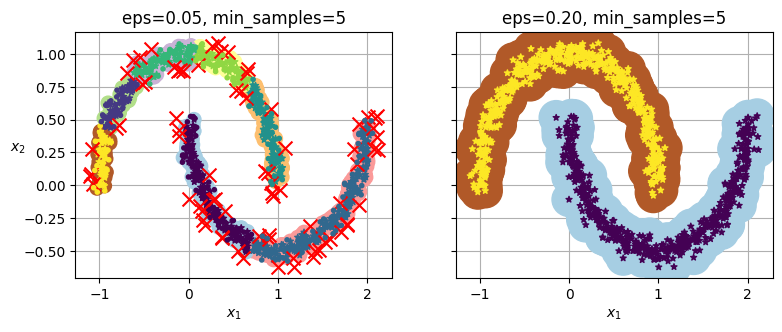

In [64]:
# extra code – this cell generates Figure 8–14

def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)


plt.show()

In [65]:
dbscan = dbscan2  # extra code – the text says we now use eps=0.2

In [66]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

,n_neighbors,50
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [67]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [68]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

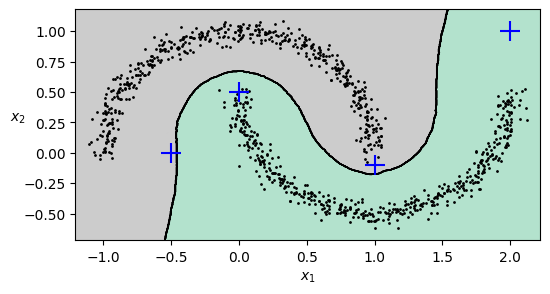

In [69]:
# extra code – this cell generates Figure 8–15

plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)

plt.show()

In [70]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## Other Clustering Algorithms

### Spectral Clustering

In [71]:
from sklearn.cluster import SpectralClustering

In [72]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

,n_clusters,2
,eigen_solver,None
,n_components,None
,random_state,42
,n_init,10
,gamma,100
,affinity,'rbf'
,n_neighbors,10
,eigen_tol,'auto'
,assign_labels,'kmeans'
,degree,3


In [73]:
sc1.affinity_matrix_.round(2)

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 1. , 0.3, ..., 0. , 0. , 0. ],
       [0. , 0.3, 1. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 1. ]], shape=(1000, 1000))

In [74]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

,n_clusters,2
,eigen_solver,None
,n_components,None
,random_state,42
,n_init,10
,gamma,1
,affinity,'rbf'
,n_neighbors,10
,eigen_tol,'auto'
,assign_labels,'kmeans'
,degree,3


In [75]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True,
                             show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"RBF gamma={sc.gamma}")

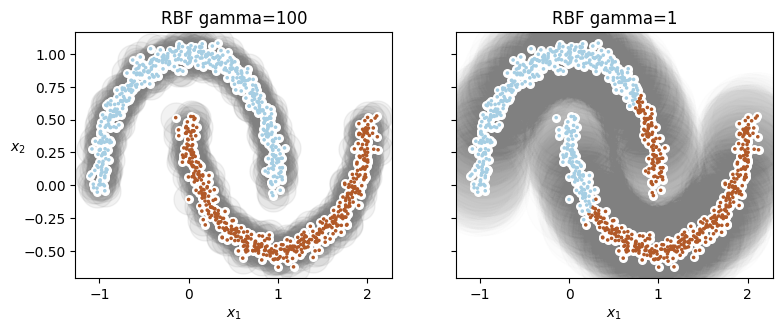

In [76]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

### Agglomerative Clustering

In [77]:
from sklearn.cluster import AgglomerativeClustering

In [78]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [79]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [80]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [81]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

# Gaussian Mixtures

Vamos gerar o mesmo conjunto de dados anteriores com três elipsoides (aquele com o qual o K-Means teve problemas):

In [82]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Vamos treinar um modelo de mistura gaussiana no conjunto de dados anterior:

In [83]:
from sklearn.mixture import GaussianMixture

In [84]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

,n_components,3
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,10
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


Vejamos os parâmetros que o algoritmo EM estimou:

In [85]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [86]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [87]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

O algoritmo realmente convergiu?

In [88]:
gm.converged_

True

Sim, ótimo. Quantas iterações foram necessárias?

In [89]:
gm.n_iter_

4

Agora você pode usar o modelo para prever a qual cluster cada instância pertence (clustering rígido) ou as probabilidades de ela ter vindo de cada cluster. Para isso, basta usar o método `predict()` ou o método `predict_proba()`:

In [90]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1], shape=(1250,))

In [91]:
gm.predict_proba(X).round(3)

array([[0.   , 0.023, 0.977],
       [0.001, 0.016, 0.983],
       [1.   , 0.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]], shape=(1250, 3))

Este é um modelo generativo, então você pode amostrar novas instâncias dele (e obter seus rótulos):

In [92]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [93]:
y_new

array([0, 0, 1, 1, 1, 2])

Observe que eles são amostrados sequencialmente de cada cluster.

Você também pode estimar o logaritmo da _função de densidade de probabilidade_ (PDF) em qualquer local usando o método `score_samples()`:

In [94]:
gm.score_samples(X).round(2)

array([-2.61, -3.57, -3.33, ..., -3.51, -4.4 , -3.81], shape=(1250,))

Vamos verificar se a PDF integra-se a 1 em todo o espaço. Simplesmente pegamos um quadrado grande ao redor dos clusters e o dividimos em uma grade de quadrados minúsculos. Em seguida, calculamos a probabilidade aproximada de que as instâncias serão geradas em cada quadrado minúsculo (multiplicando a PDF em um canto do quadrado minúsculo pela área do quadrado) e, finalmente, somando todas essas probabilidades. O resultado é muito próximo de 1:

In [95]:
# extra code – bonus material

resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

np.float64(0.9999999999225094)

Agora vamos plotar os limites de decisão resultantes (linhas tracejadas) e os contornos de densidade:

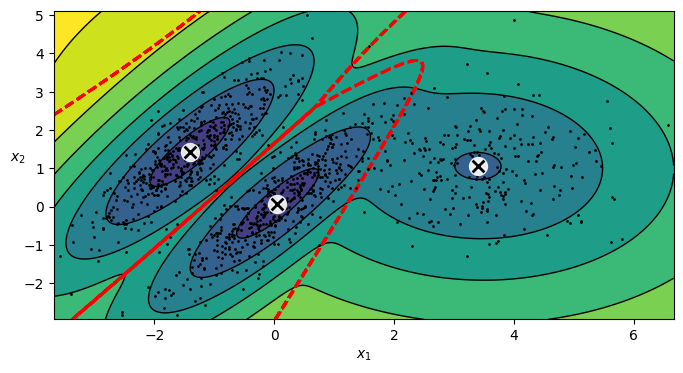

In [96]:
# extra code – this cells generates Figure 8–16

from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)


plt.show()

Você pode impor restrições às matrizes de covariância que o algoritmo procura definindo o hiperparâmetro `covariance_type`:
* `"spherical"`: todos os clusters devem ser esféricos, mas podem ter diâmetros diferentes (ou seja, variâncias diferentes).
* `"diag"`: os clusters podem assumir qualquer formato elipsoidal de qualquer tamanho, mas os eixos do elipsoide devem ser paralelos aos eixos (ou seja, as matrizes de covariância devem ser diagonais).
* `"tied"`: todos os clusters devem ter o mesmo formato, que pode ser qualquer elipsoide (ou seja, todos compartilham a mesma matriz de covariância).
* `"full"` (padrão): sem restrição, todos os clusters podem assumir qualquer formato elipsoidal de qualquer tamanho.

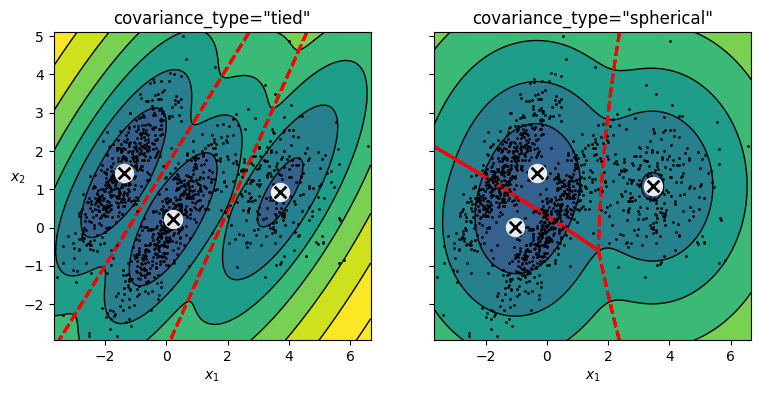

In [97]:
# extra code – this cell generates Figure 8–17

gm_full = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10,
                               covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title(f'covariance_type="{gm1.covariance_type}"')

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title(f'covariance_type="{gm2.covariance_type}"')

compare_gaussian_mixtures(gm_tied, gm_spherical, X)


plt.show()

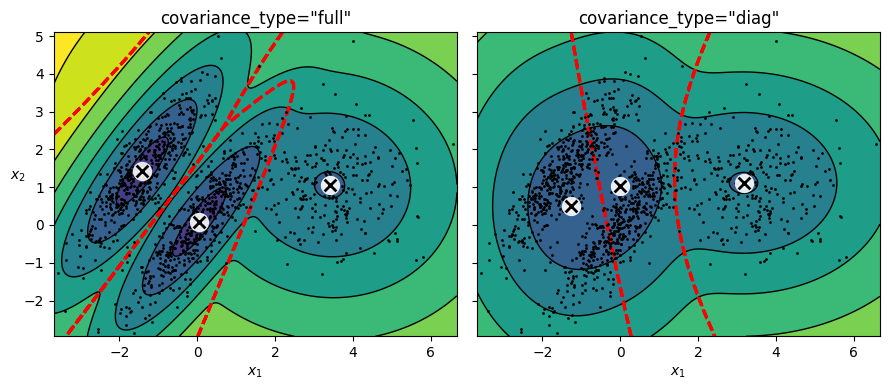

In [98]:
# extra code – comparing covariance_type="full" and covariance_type="diag"
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Anomaly Detection Using Gaussian Mixtures

Misturas Gaussianas podem ser usadas para _detecção de anomalias_: instâncias localizadas em regiões de baixa densidade podem ser consideradas anomalias. Você deve definir qual limite de densidade deseja usar. Por exemplo, em uma empresa de manufatura que tenta detectar produtos defeituosos, a proporção de produtos defeituosos geralmente é bem conhecida. Digamos que seja igual a 2%, então você pode definir o limite de densidade como o valor que resulta em 2% das instâncias localizadas em áreas abaixo desse limite de densidade:

In [99]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

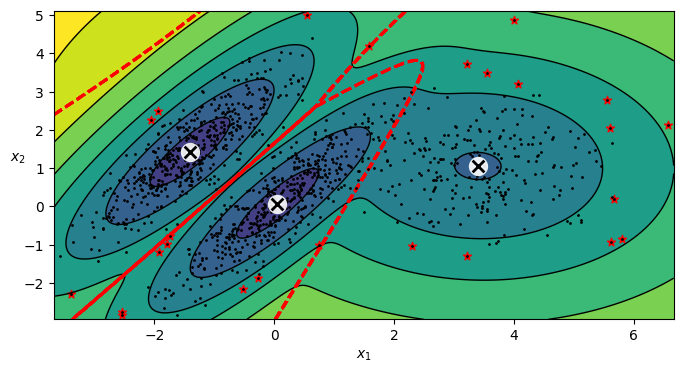

In [100]:
# extra code – this cell generates Figure 8–18

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)


plt.show()

## Selecting the Number of Clusters

Não podemos usar a inércia ou a pontuação da silhueta porque ambas pressupõem que os clusters são esféricos. Em vez disso, podemos tentar encontrar o modelo que minimiza um critério de informação teórico, como o Critério de Informação Bayesiano (BIC) ou o Critério de Informação de Akaike (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ é o número de instâncias.
* $p$ é o número de parâmetros aprendidos pelo modelo.
* $\hat L$ é o valor maximizado da função de verossimilhança do modelo. Esta é a probabilidade condicional dos dados observados $\mathbf{X}$, dados o modelo e seus parâmetros otimizados.

Tanto o BIC quanto o AIC penalizam modelos que têm mais parâmetros para aprender (por exemplo, mais clusters) e recompensam modelos que se ajustam bem aos dados (ou seja, modelos que dão alta probabilidade aos dados observados).

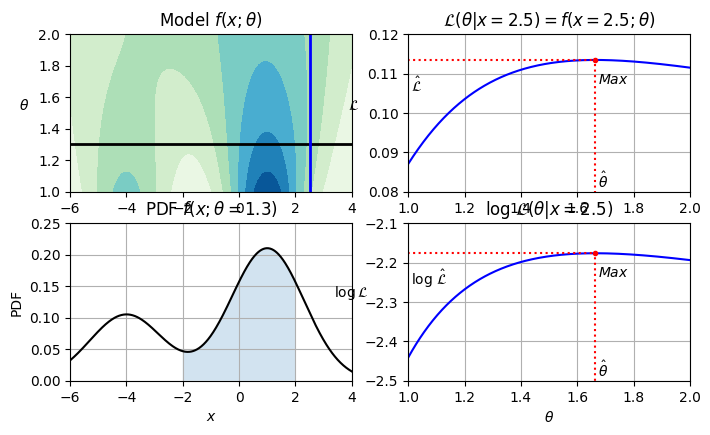

In [101]:
# extra code – this cell generates Figure 8–19

from scipy.stats import norm

x_val = 2.5
std_val = 1.3
x_range = [-6, 4]
x_proba_range = [-2, 2]
stds_range = [1, 2]

xs = np.linspace(x_range[0], x_range[1], 501)
stds = np.linspace(stds_range[0], stds_range[1], 501)
Xs, Stds = np.meshgrid(xs, stds)
Z = 2 * norm.pdf(Xs - 1.0, 0, Stds) + norm.pdf(Xs + 4.0, 0, Stds)
Z = Z / Z.sum(axis=1)[:, np.newaxis] / (xs[1] - xs[0])

x_example_idx = (xs >= x_val).argmax()  # index of the first value >= x_val
max_idx = Z[:, x_example_idx].argmax()
max_val = Z[:, x_example_idx].max()
s_example_idx = (stds >= std_val).argmax()
x_range_min_idx = (xs >= x_proba_range[0]).argmax()
x_range_max_idx = (xs >= x_proba_range[1]).argmax()
log_max_idx = np.log(Z[:, x_example_idx]).argmax()
log_max_val = np.log(Z[:, x_example_idx]).max()

plt.figure(figsize=(8, 4.5))

plt.subplot(2, 2, 1)
plt.contourf(Xs, Stds, Z, cmap="GnBu")
plt.plot([-6, 4], [std_val, std_val], "k-", linewidth=2)
plt.plot([x_val, x_val], [1, 2], "b-", linewidth=2)
plt.ylabel(r"$\theta$", rotation=0, labelpad=10)
plt.title(r"Model $f(x; \theta)$")

plt.subplot(2, 2, 2)
plt.plot(stds, Z[:, x_example_idx], "b-")
plt.plot(stds[max_idx], max_val, "r.")
plt.plot([stds[max_idx], stds[max_idx]], [0, max_val], "r:")
plt.plot([0, stds[max_idx]], [max_val, max_val], "r:")
plt.text(stds[max_idx]+ 0.01, 0.081, r"$\hat{\theta}$")
plt.text(stds[max_idx]+ 0.01, max_val - 0.006, r"$Max$")
plt.text(1.01, max_val - 0.008, r"$\hat{\mathcal{L}}$")
plt.ylabel(r"$\mathcal{L}$", rotation=0, labelpad=10)
plt.title(fr"$\mathcal{{L}}(\theta|x={x_val}) = f(x={x_val}; \theta)$")
plt.grid()
plt.axis([1, 2, 0.08, 0.12])

plt.subplot(2, 2, 3)
plt.plot(xs, Z[s_example_idx], "k-")
plt.fill_between(xs[x_range_min_idx:x_range_max_idx+1],
                 Z[s_example_idx, x_range_min_idx:x_range_max_idx+1], alpha=0.2)
plt.xlabel(r"$x$")
plt.ylabel("PDF")
plt.title(fr"PDF $f(x; \theta={std_val})$")
plt.grid()
plt.axis([-6, 4, 0, 0.25])

plt.subplot(2, 2, 4)
plt.plot(stds, np.log(Z[:, x_example_idx]), "b-")
plt.plot(stds[log_max_idx], log_max_val, "r.")
plt.plot([stds[log_max_idx], stds[log_max_idx]], [-5, log_max_val], "r:")
plt.plot([0, stds[log_max_idx]], [log_max_val, log_max_val], "r:")
plt.text(stds[log_max_idx]+ 0.01, log_max_val - 0.06, r"$Max$")
plt.text(stds[log_max_idx]+ 0.01, -2.49, r"$\hat{\theta}$")
plt.text(1.01, log_max_val - 0.08, r"$\log \, \hat{\mathcal{L}}$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\log\mathcal{L}$", rotation=0, labelpad=10)
plt.title(fr"$\log \, \mathcal{{L}}(\theta|x={x_val})$")
plt.grid()
plt.axis([1, 2, -2.5, -2.1])


plt.show()

In [102]:
gm.bic(X)

np.float64(8189.733705221638)

In [103]:
gm.aic(X)

np.float64(8102.5084251066)

Poderíamos calcular o BIC manualmente assim:

In [104]:
# extra code – bonus material
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood
print(f"bic = {bic}")
print(f"aic = {aic}")
print(f"n_params = {n_params}")

bic = 8189.733705221638
aic = 8102.5084251066
n_params = 17


Há um peso por cluster, mas a soma deve ser igual a 1, então temos um grau de liberdade a menos, daí o -1. Da mesma forma, os graus de liberdade para uma matriz de covariância $n \times n$ não são $n^2$, mas $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

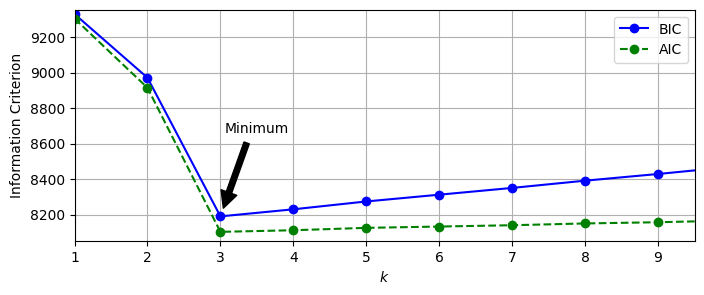

In [105]:
# extra code – this cell generates Figure 8–20

gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50])
plt.annotate("", xy=(3, bics[2]), xytext=(3.4, 8650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(3.5, 8660, "Minimum", horizontalalignment="center")
plt.legend()
plt.grid()

plt.show()

## Bayesian Gaussian Mixture Models

Em vez de procurar manualmente o número ideal de clusters, é possível usar a classe `BayesianGaussianMixture`, que é capaz de atribuir pesos iguais (ou próximos) a zero a clusters desnecessários. Basta definir o número de componentes para um valor que você acredita ser maior que o número ideal de clusters, e o algoritmo eliminará os clusters desnecessários automaticamente.

In [106]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, max_iter=500,
                              random_state=42)
bgm.fit(X)
bgm.weights_.round(2)

array([0.4 , 0.21, 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

O algoritmo detectou automaticamente que apenas 3 componentes são necessários!

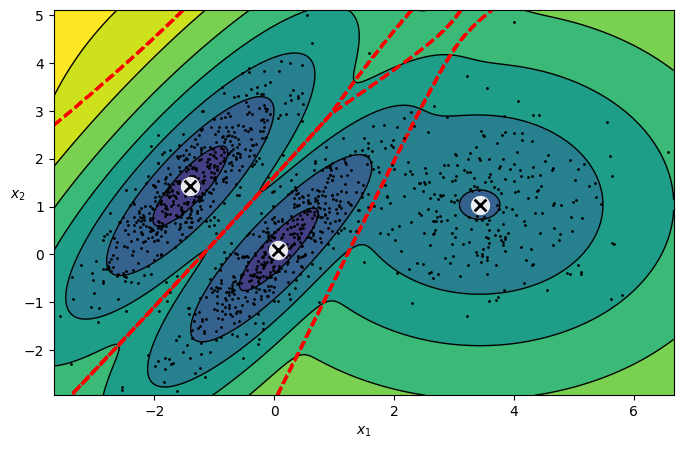

In [107]:
# extra code – this figure is almost identical to Figure 8–16
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

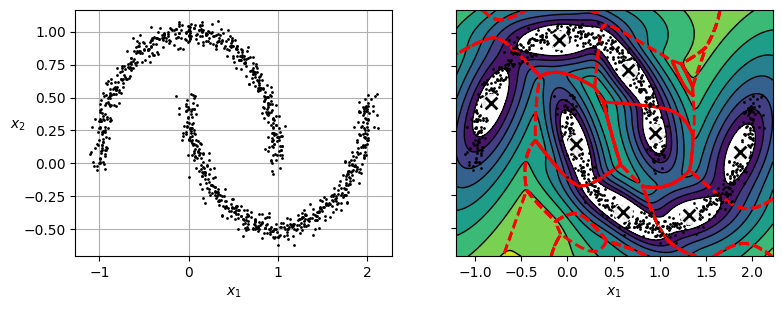

In [108]:
# extra code – this cell generates Figure 8–21

X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

bgm = BayesianGaussianMixture(n_components=10, n_init=10, max_iter=500, random_state=42)
bgm.fit(X_moons)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.grid()

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)


plt.show()

Ops, não foi ótimo... em vez de detectar 2 aglomerados em forma de lua, o algoritmo detectou 8 aglomerados elipsoidais. No entanto, o gráfico de densidade não parece tão ruim, então pode ser útil para detecção de anomalias.